# Boosting and Bagging
Boosting and bagging are two completely different ways of combining or "ensembling" statistical models. This small Python notebook aims at explaining and visualizing the difference between the two very successful approaches of combining models.  

## Bagging
Here, a couple of overfitted models (low bias but high variance) are fitted in parallel and then averaged. Averaging reduces variance as long as the models are not 100% correlated with each other. This is ensured by running the models on different bootstrap samples of the original data set. The word *bagging* comes from combining the words *bootstrap* and *aggregating*. The more bagging rounds, the better. 

Usually, the individual models fitted are deep decision trees. Most prominent implementation is the random forest as introduced by Breiman et al. There, besides the boostrapping of the data rows, another random factor is introduced to make the trees a bit less correlated and thus the related ensemble more stable: At each decision split, only a random subsample of `mtry` covariables are probed for splitting. Put differently, a random forest with `mtry` set to the number of covariables is a bagged tree.

## Boosting
Here, a too simple (high bias, low variance) model is fitted, e.g. a shallow decision tree. Residuals are calculated by subtracting from the response a certain proportion $0 < \eta < 1$ of the corresponding predictions. Then, these residuals are again modelled in the same way. This is repeated a couple of time until the residuals are small enough to stop. The final model used for predictions is just the sum of all of the intermediate models, weighted by the learning rate $\eta$. The optimal number of boosting rounds depends closely on $\eta$ and is usually chosen by cross-validation or similar techniques. Too many rounds will lead to an overfitted ensemble model.

Let's visualize the two approaches to model ensembling.

## Visualization
To start, we initialize some standard Python modules and sample some data from a fixed, non-linear curve. That means we will study bagging and boosting on an extremely simple setting with just one single covariable. This is ideal for visualizing how completely different the two concepts for ensembling are.

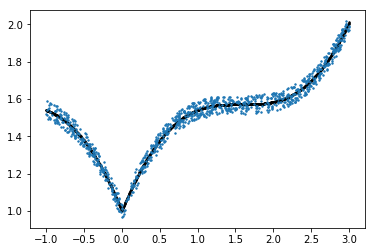

In [3]:
# Some python modules
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# The data
x = np.linspace(-1, 3, 1000).reshape(-1, 1)
def y_fun(x):
    return (np.abs(x) + np.cos(x)).reshape(-1, )
y = y_fun(x)
n = 1000
np.random.seed(8657)
xtrain = np.random.uniform(-1, 3, size=(n, 1))
ytrain = y_fun(xtrain) + np.random.uniform(-0.05, 0.05, size = (n, ))

# Visualize
plt.scatter(x, y, s=2, color='black')
plt.scatter(xtrain, ytrain, s=2)

The black lines highlights the true relationship between the only covariable and the response. The blue dots represent the data set available to reconstruct the black line as good as possible. Try to model this curve by linear regression... it works but needs careful, data-driven feature construction. 

### Visualizing boosting
To visualize boosting, let's plot the resulting predictions on a regular grid after the first boosting round, then after 20, 50, 100 and 300 rounds. The maximum number (300) was guessed as being close to ideal by cross-validation. As modelling workhorse, we picked the famous XGBoost implementation.

Wall time: 5.01 s
Wall time: 1.42 s


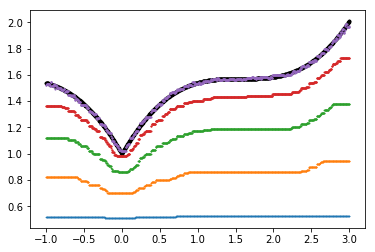

In [6]:
dtrain = xgb.DMatrix(xtrain, label = ytrain)
dtest = xgb.DMatrix(x)

params = {"objective": "reg:linear", 
          "eval_metric": "rmse",
          "eta": 0.02,
          "max_depth": 6,
          "max_leaf_nodes": 31}

# Use cross-validation to figure out a reasonable number of boosting rounds
%time xgb_cv = xgb.cv(params, dtrain, num_boost_round=1000, early_stopping_rounds=50, nfold=5)
xgb_cv.tail(1) # around 300 rounds seem to be fine

%time xgb_model = xgb.train(params, dtrain, num_boost_round=500)

plt.figure()
plt.scatter(x, y, s=7, color='black')
for i, num_trees in enumerate([1, 20, 50, 100, 300]):
    xgb_pred = xgb_model.predict(dtest, ntree_limit=num_trees)
    plt.scatter(x, xgb_pred, s=i+1, marker=".")

After the first boosting round, the predictions (blue) are still far away from the true (black) relationship. Consequently, the residuals are still very large in absolute value. The orange line shows the boosting model's overall predictions after a total of 20 rounds. Clearly, there is a trend to move towards the "correct" black line at the top. After 300 rounds (purple), the final model well approximates the underlying relationship.

### Visualizing bagging
Similarly, we plot the predictions of 1 round of bagging, after two rounds and after 100 rounds. The behaviour is completely different from boosting:

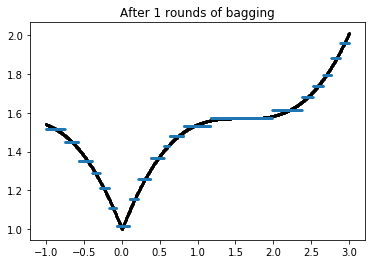

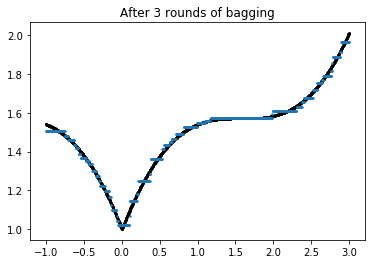

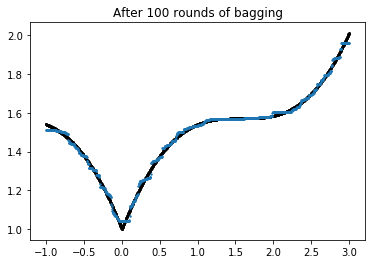

In [13]:
def plot_rf(num_trees):
    """ Visualizes bagging fit
    Plots true underlying relationship along with the predicted values by bagging.
    
    Arguments
    - num_trees: Number of trees/bagging size
    """
    plt.figure()
    plt.scatter(x, y, s=4, color='black')
    plt.title("After " + str(num_trees) + " rounds of bagging")
    rf_model = RandomForestRegressor(n_estimators=num_trees, max_leaf_nodes=20, max_features=1, random_state=345)
    rf_model.fit(xtrain, ytrain)
    rf_pred = rf_model.predict(x)
    plt.scatter(x, rf_pred, s=2)
    return None

plot_rf(1)    
plot_rf(3)
plot_rf(100)


In contrast to boostin, the model is already very close to the black line after just one round of bagging. The jumps of this single decision tree are still clearly visible. After three rounds, the jumps remain to be visible, but to a lesser extend. Finally, after 100 rounds, the predicted curve looks quite smooth and closely follow the true signal. 

## Wrap up
Bagging and boosting are two very successful, but completely different model ensembling approaches. While boosting combines iteratively a couple of underfitting models, bagging combines parallel overfitting models.